<a href="https://colab.research.google.com/github/jordi1215/qiskit-fall-fest-2021/blob/main/fall_fest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Is Random Number Generation (RNG) actually random?
Random numbers are seen around us everywhere, from assigning treatments in experiments to picking lottery winners. But when we use a computer to generate these random numbers, most of the time they only appear to be random--there’s actually an algorithm behind those numbers, and if you knew the algorithm, you’d know what number would come next! Doesn’t sound very random, right?

In this notebook, we'll go over how random number generation works in both classical and quantum computers.


In [ ]:
# install qiskit
!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

# import qiskit tools
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, Aer, IBMQ
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.providers.aer import noise

# import python utilities
import matplotlib.pyplot as plt
import numpy as np
import time

aer_sim = qiskit.Aer.get_backend('aer_simulator')

## Classical Random Number Generation

It’s hard for classical computers to generate truly random numbers because they are **deterministic**, meaning that there is always a set of instructions to determine the computer’s actions. 
There are ways to generate truly random numbers using classical computers, but they involve taking a sample of an external random physical phenomenon. This is disadvantageous because it:
- Requires extra hardware to measure the phenomena
- Takes more time to measure data

This is where **pseudorandomness** comes into play, which allows us to generate a sequence of numbers that look random, but actually are deterministic. With classical programming, you can get a random string of bits by iterating through this list, starting from a certain index in the list called a **seed**. If we generate a new list starting from the same seed, it will give us the exact same sequence of bits. However, if we reseed, we can get a new random string of bits.

In [ ]:
# set seed number (can be anything)
seed = 7

# generate sequence of random bits using seed
np.random.seed(seed)
random_bits_1 = "".join([str(i) for i in np.random.randint(0,2,1000)])

# reseed to same number and generate new sequence of random bits
np.random.seed(seed)
random_bits_2 = "".join([str(i) for i in np.random.randint(0,2,1000)])

# after printing, we see the bit-strings are the same
print("Random bitstring with seed:\t", random_bits_1)
print("Random bitstring with same seed:", random_bits_2)

# reseed with different seed and generate different random bit-string
np.random.seed()
random_bits_3 = "".join([str(i) for i in np.random.randint(0,2,1000)])
print("Random bitstring with new seed:\t", random_bits_3)

Random bitstring with seed:	 10101111010101000010001100110010011001101100010000111101010001100011011011101010111111110111011111110100111101001111010000101110010000111101110011000101011101100111000000000010001100111100100011111010110011101001111001011010111010011101111100101100010100111111100011011110010000010011010010001110010000100001111011000010111100001101000010011110111001110011111000100100001100011001000010110010100111110110000000100001111000101101100001010111001100001101110011111110110101011001001110100100101000111110011110001000011000001000110110101110000001111100000100110110101001101000100100001000100011001110100000000101000011001110100010110110000111000000101001000101000010001110011010111011001010110010010001110100010010100001010101001100111110101000101100101111000111110000101101010010001110101111010101101000001010010010001110100101001000011010111010001110101110100010110010111001101000101101001111000111011110001100010011110011110110101000101111101101110100000101110011001100110

## Quantum Random Number Generation

We now demonstrate how quantum computing will get the best of both worlds (truly random numbers without the disadvantages outlined above)! For this, we rely on one of the most important concepts of quantum computing: the **qubit**, which is the fundamental unit of information storage and manipulation in a quantum computer. When we put a qubit into **superposition**, we put it into a state where we do not know if it will take on the value 0 or 1 until we measure it. However, we can control the probabilities that the qubit will collapse to either 0 or 1. 
Let’s say we have a quantum circuit with our one qubit. If we make the probability of it collapsing to 0 to be $50\%$, and the probability of it collapsing to 1 to be 50% using a **Hadamard gate**, then we can randomly generate a number between 0 and 1! This is represented in the state diagram below as the $|+\rangle$ state. (When a qubit has a $100\%$ chance of being measured as 0, it is in the $|0\rangle$ state, and the same logic applies to the $|1\rangle$ state.)

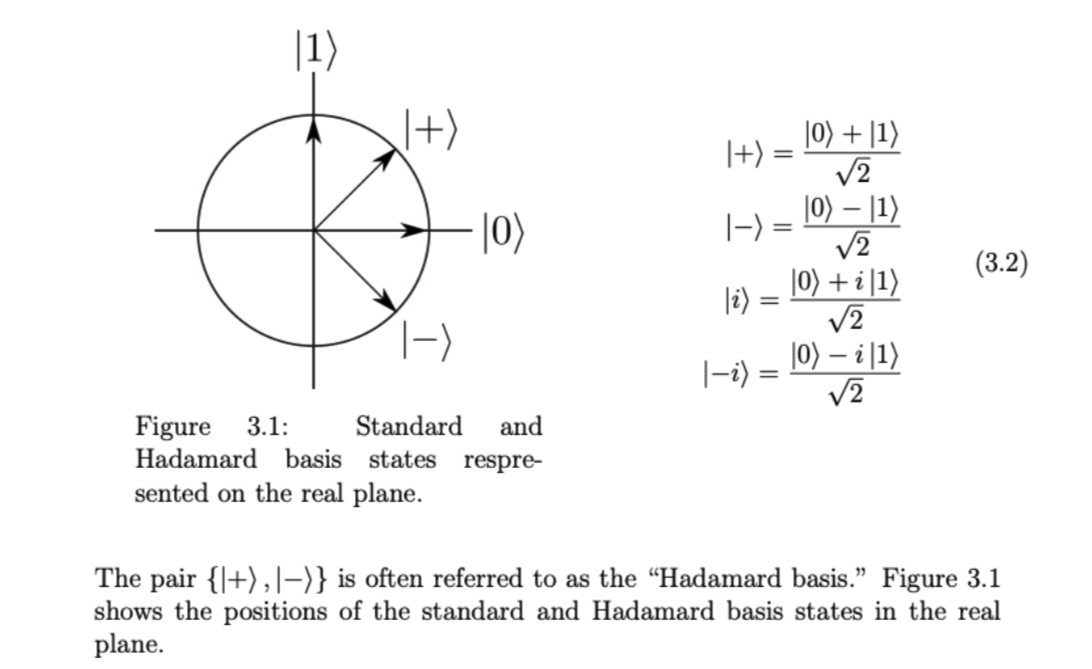

Quantum computers are different from classical computers in the sense that they have the ability to generate truly random numbers without any external sampling. One way to do this is to put a qubit in a perfect superposition of the $|0\rangle$ and $|1\rangle$ states. This is done by applying a Hadamard gate, shifting the qubit to the Hadamard basis described above.

In [ ]:
def stage_one_circuit():
    """Create quantum circuit for random number generation"""
    qc = QuantumCircuit(1,1)
    qc.h(0)
    qc.measure(0,0)
    return qc

In [ ]:
# print out resulting circuit
circuit = stage_one_circuit()
circuit.draw()

┌───┐┌─┐
q_0: ┤ H ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0

We can then measure the qubit in the standard basis, giving us 0 or 1 with equal probability. This method has no reliance on seeds, so repeating the process multiple times will give us completely different random bits.

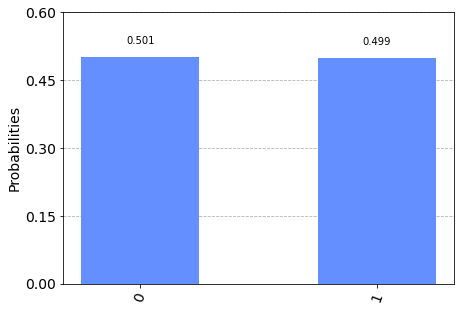

In [ ]:
# display distribution of 0's and 1's
result = aer_sim.run(circuit).result()
counts = result.get_counts()
qiskit.visualization.plot_histogram(counts)

Great! Simply using our knowledge about a qubit’s properties, we can generate random numbers using our quantum circuit, and can also generate numbers bigger than 1 simply by stringing our bits together, all without having to get extra hardware or take the time to gather data on an external phenomenon.

In [ ]:
def stage_one_random_bit_generator(random_bits_length):
    """Generate string of random bits
        input -- random_bits_length: the length of the resultant string
        output -- random_bits: string of random bits
                  ones: number of ones in random bitstring
                  zeros: number of zeros in random bitstring
    """
    # initialize empty string, counts, and circuit
    random_bits = ''
    total_count = 0
    ones = 0
    zeros = 0
    simple_circuit = stage_one_circuit()

    # loop until random_bits is of length random_bits_length
    while len(random_bits) < random_bits_length:
        total_count += 1

        # run simulation and store result
        job_result = aer_sim.run(simple_circuit, shots=1).result()
        result_keys = job_result.get_counts().keys()
        result_int = int(list(result_keys)[0])

        # increment ones or zeros and add bit to string
        if result_int == 1:
            ones += 1
        else:
            zeros += 1
        random_bits += str(result_int)

    return random_bits, ones, zeros

In [ ]:
print("One random string:\t", stage_one_random_bit_generator(100)[0])
print("Another random string:\t", stage_one_random_bit_generator(100)[0])

One random string:	 0000100110011010010111000110100101110101111001001001000000111011111000100010000101010100011011100011
Another random string:	 1110011101011010010101010011010110001011100001000011101101011110100111101111011101110110010110000001


The method of random number generation outlined above is very effective on idealized quantum circuits, but in reality, noise or imperfect state preparation may interfere with our random generation. 

We now introduce a slightly different quantum method for generating random numbers.

## The CHSH Game
In this process, we develop a quantum strategy for a nonlocal game called the "CHSH game." This game is used to verify the true validity of quantum number generation.

In the CHSH game, Alice and Bob receive independent random bits 
$x$ and $y$ respectively from Charlie, the referee. Their goal is to output bits $a$ and $b$ respectively 
such that $a+b=xy \pmod{2}$. No communication is allowed.

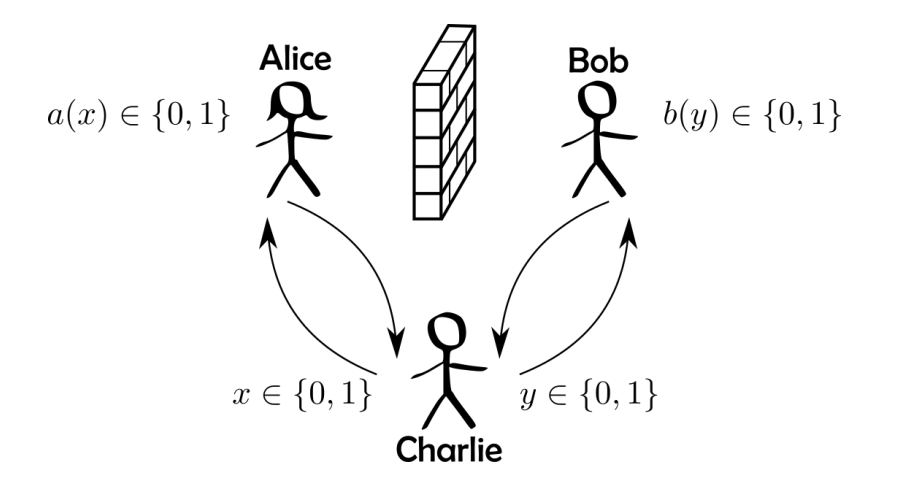

In classical computing, we can calculate the probability of Alice and Bob winning the game by simply enumerating all of the cases for $x$, $y$, $a$, and $b$. As shown below, the highest probability we attain is $75\%$, corresponding to Alice and Bob following the strategy of always sending 0 or always sending 1.

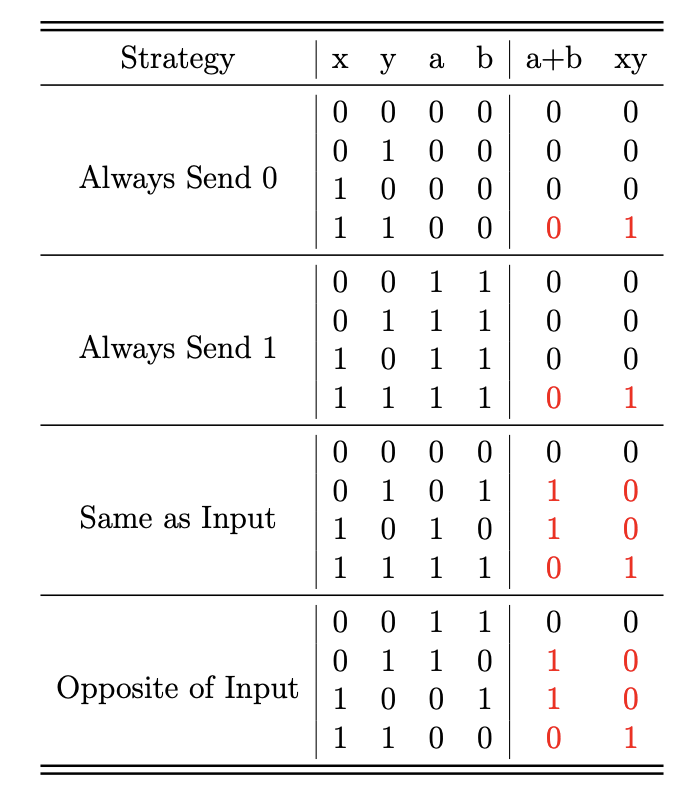

We can significantly increase our chances of winning if using a quantum computer. 

*CHSH quantum protocol*: 

In an optimal quantum strategy for the game, Alice does the following:

- If $x=0$, do nothing to her qubit
- If $x=1$, apply a $\frac{\pi}{4}$ counterclockwise rotation towards $|1\rangle$ on her qubit

Bob does the following:
- if $y=0$, apply a $\frac{\pi}{8}$ counterclockwise rotation towards $|1\rangle$ on his qubit
- if $y=1$, apply a $\frac{\pi}{8}$ clockwise rotation towards $|1\rangle$ on his qubit

Alice and Bob both measure 
their qubits in the $\{|0\rangle,|1\rangle \}$ basis and output whatever they see. 
This strategy wins $\cos^2\left(\frac{\pi}{8}\right) \approx 85\%$ of the time, an improvement compared to the $75\%$ chance of winning using the classical strategy. 

In [ ]:
def make_chsh(x, y):
    """Create quantum circuit for CHSH protocol.
      input -- x: the x input for the CHSH non-local game
               y: the y input for the CHSH non-local game

      output -- qc: CHSH circuit created
    """
    # initialize quantum circuit with 2 qubits and 2 classical bits
    qc = QuantumCircuit(2,2)

    # apply Hadamard gate and control-not
    qc.h(0)
    qc.cx(0, 1)
    
    # apply conditional rotations
    # need to multiply the angle of rotation by 2 since Qiskit divides the angle by 2 when applying the rotation
    if x == 1:
        qc.ry(np.pi/2, 0)
    if y == 0:
        qc.ry(np.pi/4, 1)
    elif y == 1:
        qc.ry(-np.pi/4, 1)
    qc.measure(range(2),range(2))
    
    return qc

Below, we can see that Alice and Bob's qubits result in the winning states $|00\rangle$ or $|11\rangle$ around $85\%$ of the time when $x=0$ and $y=1$.

In [ ]:
# visualize and run CHSH circuit for x = 0, y = 1
chsh_circuit = make_chsh(0,1)
result = aer_sim.run(chsh_circuit).result()
counts = result.get_counts()
chsh_circuit.draw()

┌───┐                 ┌─┐   
q_0: ┤ H ├──■──────────────┤M├───
     └───┘┌─┴─┐┌──────────┐└╥┘┌─┐
q_1: ─────┤ X ├┤ Ry(-π/4) ├─╫─┤M├
          └───┘└──────────┘ ║ └╥┘
c: 2/═══════════════════════╩══╩═
                            0  1

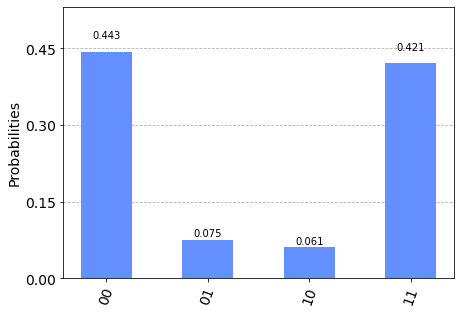

In [ ]:
qiskit.visualization.plot_histogram(counts)

The other two cases when $xy=0 \pmod{2}$ also result in an $85\%$ win rate.

When $x=1$, $y=0$,

In [ ]:
# run CHSH circuit with x=1 and y=0, display results
chsh_circuit = make_chsh(1,0)
result = aer_sim.run(chsh_circuit).result()
counts = result.get_counts()
chsh_circuit.draw()

┌───┐     ┌─────────┐┌─┐   
q_0: ┤ H ├──■──┤ Ry(π/2) ├┤M├───
     └───┘┌─┴─┐├─────────┤└╥┘┌─┐
q_1: ─────┤ X ├┤ Ry(π/4) ├─╫─┤M├
          └───┘└─────────┘ ║ └╥┘
c: 2/══════════════════════╩══╩═
                           0  1

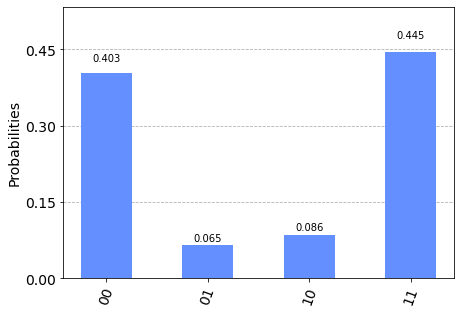

In [ ]:
qiskit.visualization.plot_histogram(counts)

When $x=0$, $y=0$,

In [ ]:
# run CHSH circuit with x=0 and y=0, display results
chsh_circuit = make_chsh(0,0)
result = aer_sim.run(chsh_circuit).result()
counts = result.get_counts()
chsh_circuit.draw()

┌───┐                ┌─┐   
q_0: ┤ H ├──■─────────────┤M├───
     └───┘┌─┴─┐┌─────────┐└╥┘┌─┐
q_1: ─────┤ X ├┤ Ry(π/4) ├─╫─┤M├
          └───┘└─────────┘ ║ └╥┘
c: 2/══════════════════════╩══╩═
                           0  1

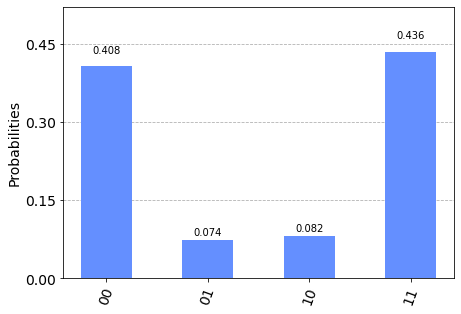

In [ ]:
qiskit.visualization.plot_histogram(counts)

When $x=1$ and $y=1$, the winning states are $|01\rangle$ and $|10\rangle$. The winning states are still achieved about $85\%$ of the time.

In [ ]:
# run CHSH circuit with x=1 and y=1, display results
chsh_circuit = make_chsh(1,1)
result = aer_sim.run(chsh_circuit).result()
counts = result.get_counts()
chsh_circuit.draw()

┌───┐     ┌─────────┐ ┌─┐   
q_0: ┤ H ├──■──┤ Ry(π/2) ├─┤M├───
     └───┘┌─┴─┐├─────────┴┐└╥┘┌─┐
q_1: ─────┤ X ├┤ Ry(-π/4) ├─╫─┤M├
          └───┘└──────────┘ ║ └╥┘
c: 2/═══════════════════════╩══╩═
                            0  1

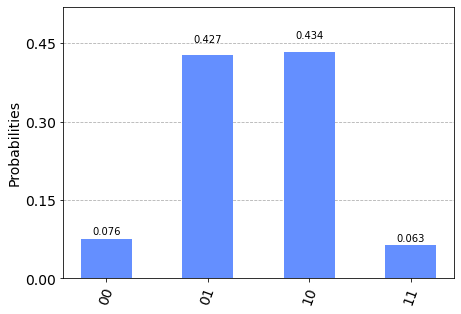

In [ ]:
qiskit.visualization.plot_histogram(counts)

## Random Bit Generation Using CHSH

We can now use this game to generate random bits. We can play the game and append Alice's resulting bit to our random bitstring, discarding any losing rounds where Alice and Bob lost the game.

In [ ]:
def stage_two_random_bit_generator(random_bits_length):
    """Generate random string of bits using stage two method.
      input -- random_bits_length: the length of the resulting string

      output -- random_bits: string of random bits
                success_rate: percent of CHSH games that were a win
                ones: number of ones in resulting string
                zeros: number of zeros in resulting string
    """
    # initialize counts and empty string
    random_bits = ''
    total_count = 0
    ones = 0
    zeros = 0

    # loop until number of random bits is equal to random_bits_length
    while len(random_bits) < random_bits_length:
        total_count += 1

        # construct chsh circuit with two classically random bits
        x,y = np.random.randint(0,2,2)
        chsh_circuit = make_chsh(x,y)

        # run circuit one time and store result
        job_result = aer_sim.run(chsh_circuit, shots=1).result()
        result_keys = job_result.get_counts().keys()
        result_str = list(result_keys)[0]

        # check if result satisfies win condition
        a = int(result_str[1])
        b = int(result_str[0])
        measured_result = (a + b) % 2
        predicted_result = x*y
        if measured_result == predicted_result:

            # append bit if win condition satisfied
            random_bits += str(a)
            if a == 1:
              ones += 1
            else:
              zeros += 1

    # calculate win rate and return
    success_rate = np.round(random_bits_length / total_count,3)
    return random_bits, success_rate, ones, zeros

Running our above function, we see that our win rate is around $85\%$ as expected. This gives us a relatively even distribution of 1's and 0's.

In [ ]:
length = 10000
bit_string, percentage, ones, zeros = stage_two_random_bit_generator(length)
print("Game winning rate: ", percentage * 100,"%")
print("Percentage of 1\'s: ", ones/length * 100,"%")
print("Percentage of 0\'s: ", zeros/length * 100,"%")
print("Generated string:", bit_string)

Game winning rate:  85.7 %
Percentage of 1's:  49.5 %
Percentage of 0's:  50.5 %
Generated string: 0111000010111110011100000010011010101100101010101010101010000100101010010011001010000011110011010001000101010100111100011111101111001000010011101011111110000111110001011100011110010001111001001000010010000100101101011101100000000100111001001100111010001010010010101010100001111001111111001100101000100011010100000110110111011111010110000100000111010101011111011010100100001010011100010010001101111111111010000010101101101010110110001110100110001000001001011110100101011111001110010000100110010001000101000111101010010100011111001011111010011011001010011110001100110010100001111000110110101111010101101001100101100111001111001001100011000001011100110111001100100001010111010011100110100001000010111001000101010010011000010100010011010010101111110000111000110010100011111001110101011011101100101110111101010001010011111101000111100011000101101100001110011101000110000000000101111011000110101001010001110

Below, we plot the resulting ratios from generating lengths 1 to 250. We see that the ratios are around our desired result.

In [ ]:
# set number of iterations
num_iterations = 250

# initialize empty lists
lengths = range(1, num_iterations+1)
win_rates = [None] * num_iterations
one_rates = [None] * num_iterations

# iterate over each length
for length in lengths:
    print("Iteration:", length)
    _, win_rates[length-1], one_rates[length-1], _ = stage_two_random_bit_generator(length)
    one_rates[length-1] /= length

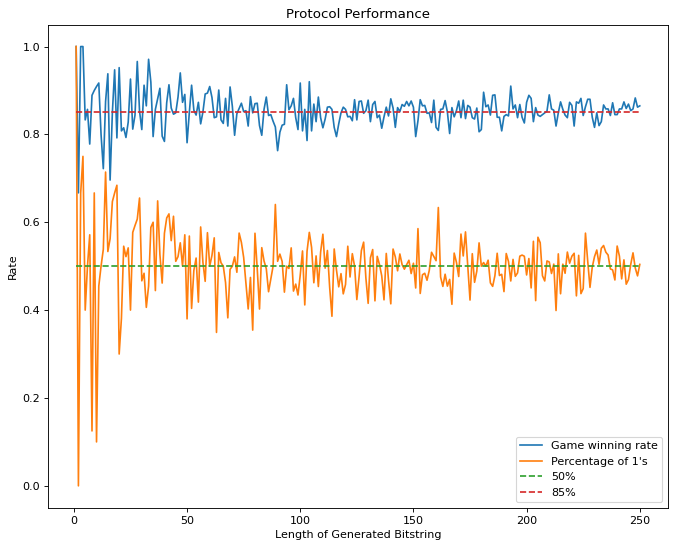

In [ ]:
plt.figure(figsize=(10, 8), dpi=80)

# plot win rates and percentage of ones
plt.plot(lengths, win_rates, label="Game winning rate")
plt.plot(lengths, one_rates, label="Percentage of 1's")

# plot desired ratios
plt.plot(lengths, [0.5]*num_iterations, label="50%", linestyle="dashed")
plt.plot(lengths, [0.85]*num_iterations, label="85%", linestyle="dashed")

# label graph
plt.xlabel("Length of Generated Bitstring")
plt.ylabel("Rate")
plt.title("Protocol Performance")
plt.legend(loc="lower right")
plt.show()

## Running on an Actual Quantum Computer

For some reason, when we sent the job to an actual quantum computer, the job gets queued up and we never got the result back no matter how long we waited. It will be good to figure out what happened.

In [ ]:
# Set devices, if using a real device
# IBMQ.save_account(TOKEN)
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
quito = provider.get_backend('ibmq_lima')

In [ ]:
# Execute and get counts
chsh_circuit = make_chsh(0,0)
#result_ideal = sim.run(chsh_circuits).result()

tic = time.time()
transpiled_circuits = transpile(chsh_circuit, quito)
job_real = quito.run(transpiled_circuits, shots=1)
job_monitor(job_real)
result_real = job_real.result()
toc = time.time()
counts = result_real.get_counts()

print(toc-tic)
qiskit.visualization.plot_histogram(counts)

Job Status: job is queued (11)    

# Future Work

We can still do better!

With our random bit generation algorithm that uses the CHSH game, we get 0.85 quantum bit of output per two classical bits of input. We could redesign a system where we recycle the quantum bits output to generate more quantum random bits!

We could possibly involve more players with this implementation.

